# **PFL pipeline**

## **Imports**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix, f1_score, classification_report, precision_score, recall_score, balanced_accuracy_score # Ensure it's here
import warnings
import copy
from sklearn.metrics import average_precision_score
import os
import json
import random

# Suppress warnings for cleaner output (optional)
warnings.filterwarnings("ignore")

# Device configuration
device = torch.device("mps")
print(f"Using device: {device}")

MAX_LOCAL_STATIC_FEATURE_DIM = 4 

Using device: mps


## **Data Preparation: Loading All Features (Static and Dynamic)**

### Custom Dataset for Time Series data

In [141]:
class ICUTimeSeriesDataset(Dataset):
    def __init__(self, X_static_common, X_static_local, X_dynamic, y):
        self.Xsc = torch.tensor(X_static_common, dtype=torch.float32)
        self.Xsl = torch.tensor(X_static_local, dtype=torch.float32)
        self.Xd = torch.tensor(X_dynamic, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.Xsc[idx], self.Xsl[idx], self.Xd[idx], self.y[idx]

### Function to load client-specific data, including both static and dynamic features

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix, f1_score, classification_report, precision_score, recall_score, balanced_accuracy_score
import warnings
import copy

# Suppress warnings for cleaner output (optional)
warnings.filterwarnings("ignore")

# Device configuration
device = torch.device("mps")
print(f"Using device: {device}")

# These are your global constants for standardizing dimensions for Per-FedAvg
FIXED_COMMON_STATIC_DIM = 6 
MAX_PADDED_LOCAL_STATIC_DIM = 4 
MAX_PADDED_DYNAMIC_DIM = 205 

class ICUTimeSeriesDataset(Dataset):
    def __init__(self, X_static_common, X_static_local, X_dynamic, y):
        self.Xsc = torch.tensor(X_static_common, dtype=torch.float32)
        self.Xsl = torch.tensor(X_static_local, dtype=torch.float32)
        self.Xd = torch.tensor(X_dynamic, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.Xsc[idx], self.Xsl[idx], self.Xd[idx], self.y[idx]

def pad_or_truncate_features(data, target_dim, axis, pad_value=0):
    """
    Pads or truncates features along a specific axis.
    For static (2D): axis=1 (padding/truncating number of features)
    For dynamic (3D): axis=2 (padding/truncating number of features per time step)
    """
    current_dim = data.shape[axis]
    if current_dim == target_dim: # Add this check to avoid unnecessary operations
        return data

    # Axis 1 for static features, axis 2 for dynamic features
    if current_dim > target_dim:
        if axis == 1: 
            return data[:, :target_dim]
        elif axis == 2: 
            return data[:, :, :target_dim]
    elif current_dim < target_dim:
        padding_needed = target_dim - current_dim
        if axis == 1: #
            pad_width = ((0, 0), (0, padding_needed))
        elif axis == 2: 
            pad_width = ((0, 0), (0, 0), (0, padding_needed))
        else:
            raise ValueError("Axis must be 1 for static or 2 for dynamic.")
        return np.pad(data, pad_width, 'constant', constant_values=pad_value)
    return data

def load_and_prepare_client_data(client_id, data_path_prefix="./", for_meta_learning=False, split_ratio=0.6, seed=42):
    try:
        if client_id == 0: # MIMIC (Client 1)
            client_name = "MIMIC-III (Client 1)"
            Xs_common_tr = np.load(f"{data_path_prefix}/MIMIC_data_handler/numpy_data_c1/Xstatic_train_match1.npy")
            Xs_common_te = np.load(f"{data_path_prefix}/MIMIC_data_handler/numpy_data_c1/Xstatic_test_match1.npy")
            Xs_local_tr = np.load(f"{data_path_prefix}/MIMIC_data_handler/numpy_data_c1/Xstatic_train_local1.npy")
            Xs_local_te = np.load(f"{data_path_prefix}/MIMIC_data_handler/numpy_data_c1/Xstatic_test_local1.npy")
            Xd_tr = np.load(f"{data_path_prefix}/MIMIC_data_handler/numpy_data_c1/Xdynamic_train_c1.npy")
            Xd_te = np.load(f"{data_path_prefix}/MIMIC_data_handler/numpy_data_c1/Xdynamic_test_c1.npy")
            y_tr = np.load(f"{data_path_prefix}/MIMIC_data_handler/numpy_data_c1/y_train_c1.npy")
            y_te = np.load(f"{data_path_prefix}/MIMIC_data_handler/numpy_data_c1/y_test_c1.npy")

        elif client_id == 1: # eICU (Client 2)
            client_name = "eICU (Client 2)"
            Xs_common_tr = np.load(f"{data_path_prefix}/eICU_data_handler/numpy_data_c2/Xstatic_train_match2.npy")
            Xs_common_te = np.load(f"{data_path_prefix}/eICU_data_handler/numpy_data_c2/Xstatic_test_match2.npy")
            Xs_local_tr = np.load(f"{data_path_prefix}/eICU_data_handler/numpy_data_c2/Xstatic_train_local2.npy")
            Xs_local_te = np.load(f"{data_path_prefix}/eICU_data_handler/numpy_data_c2/Xstatic_test_local2.npy")
            Xd_tr = np.load(f"{data_path_prefix}/eICU_data_handler/numpy_data_c2/Xdynamic_train_c2.npy") 
            Xd_te = np.load(f"{data_path_prefix}/eICU_data_handler/numpy_data_c2/Xdynamic_test_c2.npy")
            y_tr = np.load(f"{data_path_prefix}/eICU_data_handler/numpy_data_c2/y_train_c2.npy")
            y_te = np.load(f"{data_path_prefix}/eICU_data_handler/numpy_data_c2/y_test_c2.npy")
        else:
            raise ValueError(f"Invalid client_id: {client_id}. Only 0 (MIMIC) and 1 (eICU) are supported.")

        # Assert common static feature dimension is as expected but it should be handled
        if Xs_common_tr.shape[1] != FIXED_COMMON_STATIC_DIM:
            raise ValueError(f"Client {client_id} common static training features dim is {Xs_common_tr.shape[1]}, expected {FIXED_COMMON_STATIC_DIM}")
        if Xs_common_te.shape[1] != FIXED_COMMON_STATIC_DIM:
            raise ValueError(f"Client {client_id} common static test features dim is {Xs_common_te.shape[1]}, expected {FIXED_COMMON_STATIC_DIM}")

        print(f"  {client_name} - Original Xs_common_tr shape: {Xs_common_tr.shape}")
        print(f"  {client_name} - Original Xs_local_tr shape: {Xs_local_tr.shape}")
        print(f"  {client_name} - Original Xd_tr (dynamic) shape: {Xd_tr.shape}, Feature Dim: {Xd_tr.shape[2] if Xd_tr.ndim == 3 else 'N/A'}")


        if for_meta_learning:
            from sklearn.model_selection import train_test_split
            Xsc_s, Xsc_q, Xsl_s, Xsl_q, Xd_s, Xd_q, y_s, y_q = train_test_split(
                Xs_common_tr, Xs_local_tr, Xd_tr, y_tr, 
                train_size=split_ratio, stratify=y_tr, random_state=seed
            )

            support_ds = ICUTimeSeriesDataset(Xsc_s, Xsl_s, Xd_s, y_s)
            query_ds   = ICUTimeSeriesDataset(Xsc_q, Xsl_q, Xd_q, y_q)

            support_loader = DataLoader(support_ds, batch_size=64, shuffle=True, num_workers=0)
            query_loader   = DataLoader(query_ds, batch_size=64, shuffle=True, num_workers=0)
        else:
            train_ds = ICUTimeSeriesDataset(Xs_common_tr, Xs_local_tr, Xd_tr, y_tr)
            train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0)

        y_tr_flat = y_tr.astype(int).ravel() 
        counts = np.bincount(y_tr_flat) 
        count_class_0 = counts[0] if len(counts) > 0 else 0
        count_class_1 = counts[1] if len(counts) > 1 else 0
        
        print(f"Client {client_id} (Train): Total samples={len(y_tr)}, Class 0 (Dead)={count_class_0}, Class 1 (Alive/Positive for Loss)={count_class_1}")

        if not for_meta_learning:
            train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0)

        test_ds = ICUTimeSeriesDataset(Xs_common_te, Xs_local_te, Xd_te, y_te)
        test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=0)
        
        if count_class_1 > 0:
            calculated_pos_weight = float(count_class_0) / count_class_1
        else:
            calculated_pos_weight = 1.0 
            print(f"  Warning: Client {client_id} has no 'Alive' (Class 1) samples in training data for pos_weight. Using pos_weight=1.0.")
        
        if count_class_0 == 0 and count_class_1 > 0:
            print(f"  Warning: Client {client_id} has only 'Alive' (Class 1) samples and no 'Dead' (Class 0) samples for pos_weight. Calculated pos_weight is 0.0.")
        
        pos_weight = torch.tensor(calculated_pos_weight, dtype=torch.float32, device=device)
        print(f"  Calculated pos_weight (for 'Alive' class, label 1 in loss): {pos_weight.item():.2f}")

        result = {
            'test_loader': test_loader,
            'pos_weight': pos_weight,
            'common_static_dim': Xs_common_tr.shape[1],
            'local_static_dim': Xs_local_tr.shape[1],
            'dynamic_dim': Xd_tr.shape[2] if Xd_tr.ndim == 3 else 0,
            'client_name': client_name,
            'y_train': y_tr.astype(int),
            'y_test': y_te.astype(int),
        }

        if for_meta_learning:
            result['support_loader'] = support_loader
            result['query_loader'] = query_loader
        else:
            result['train_loader'] = train_loader

        return result
    
    except FileNotFoundError as e:
        print(f"Error loading data for client_id {client_id}: {e}. Please ensure your data paths are correct.")
        raise
    except Exception as e:
        print(f"An unexpected error occurred in load_and_prepare_client_data for client_id {client_id}: {e}")
        raise

Using device: mps


### Load data for all clients for PFL

In [143]:
clients = [0, 1]
all_client_data_pfl = {}

clientname = {0: "MIMIC-III (Client 1)", 1: "eICU (Client 2)"}

for cid in clients:
    all_client_data_pfl[cid] = load_and_prepare_client_data(
        client_id=cid,
        data_path_prefix="./",
        for_meta_learning=True,
        split_ratio=0.6,
        seed=42
    )

client_support_loaders = [all_client_data_pfl[cid]['support_loader'] for cid in clients]
client_query_loaders   = [all_client_data_pfl[cid]['query_loader'] for cid in clients]
client_test_loaders    = [all_client_data_pfl[cid]['test_loader'] for cid in clients]
pos_weights_pfl        = [all_client_data_pfl[cid]['pos_weight'] for cid in clients]

client_common_static_dims = {cid: all_client_data_pfl[cid]['common_static_dim'] for cid in clients}
client_local_static_dims  = {cid: all_client_data_pfl[cid]['local_static_dim'] for cid in clients}
client_dynamic_dims       = {cid: all_client_data_pfl[cid]['dynamic_dim'] for cid in clients}

# Sanity check
common_dims_set = set(client_common_static_dims.values())
if len(common_dims_set) > 1:
    raise ValueError(f"Common static dimensions differ across clients! Dims found: {common_dims_set}")


  MIMIC-III (Client 1) - Original Xs_common_tr shape: (27585, 6)
  MIMIC-III (Client 1) - Original Xs_local_tr shape: (27585, 4)
  MIMIC-III (Client 1) - Original Xd_tr (dynamic) shape: (27585, 24, 205), Feature Dim: 205
Client 0 (Train): Total samples=27585, Class 0 (Dead)=1892, Class 1 (Alive/Positive for Loss)=25693
  Calculated pos_weight (for 'Alive' class, label 1 in loss): 0.07
  eICU (Client 2) - Original Xs_common_tr shape: (34137, 6)
  eICU (Client 2) - Original Xs_local_tr shape: (34137, 3)
  eICU (Client 2) - Original Xd_tr (dynamic) shape: (34137, 24, 123), Feature Dim: 123
Client 1 (Train): Total samples=34137, Class 0 (Dead)=2441, Class 1 (Alive/Positive for Loss)=31696
  Calculated pos_weight (for 'Alive' class, label 1 in loss): 0.08


In [144]:
import numpy as np

clients = [0, 1]
all_client_data_pfl = {}

clientname = {0: "MIMIC-III (Client 1)", 1: "eICU (Client 2)"}

for cid in clients:
    all_client_data_pfl[cid] = load_and_prepare_client_data(
        client_id=cid,
        data_path_prefix="./",
        for_meta_learning=True,
        split_ratio=0.6,
        seed=42
    )
    
    # Access the y_train data for the current client
    y_train = all_client_data_pfl[cid]['y_train']
    
    # Calculate and print the class counts
    counts = np.bincount(y_train.astype(int).ravel())
    class_0_count = counts[0] if len(counts) > 0 else 0
    class_1_count = counts[1] if len(counts) > 1 else 0
    
    print(f"Client {cid} ({clientname[cid]}):")
    print(f"  Total samples: {len(y_train)}")
    print(f"  Class 0 (Dead) samples: {class_0_count}")
    print(f"  Class 1 (Alive/Positive for Loss) samples: {class_1_count}")
    
    if class_0_count < class_1_count:
        print("  Class 0 is the minority class.")
    elif class_1_count < class_0_count:
        print("  Class 1 is the minority class.")
    else:
        print("  Classes are balanced or one class is absent.")

# The rest of your code
client_support_loaders = [all_client_data_pfl[cid]['support_loader'] for cid in clients]
client_query_loaders   = [all_client_data_pfl[cid]['query_loader'] for cid in clients]
client_test_loaders    = [all_client_data_pfl[cid]['test_loader'] for cid in clients]
pos_weights_pfl        = [all_client_data_pfl[cid]['pos_weight'] for cid in clients]

client_common_static_dims = {cid: all_client_data_pfl[cid]['common_static_dim'] for cid in clients}
client_local_static_dims  = {cid: all_client_data_pfl[cid]['local_static_dim'] for cid in clients}
client_dynamic_dims       = {cid: all_client_data_pfl[cid]['dynamic_dim'] for cid in clients}

# Sanity check
common_dims_set = set(client_common_static_dims.values())
if len(common_dims_set) > 1:
    raise ValueError(f"Common static dimensions differ across clients! Dims found: {common_dims_set}")

  MIMIC-III (Client 1) - Original Xs_common_tr shape: (27585, 6)
  MIMIC-III (Client 1) - Original Xs_local_tr shape: (27585, 4)
  MIMIC-III (Client 1) - Original Xd_tr (dynamic) shape: (27585, 24, 205), Feature Dim: 205
Client 0 (Train): Total samples=27585, Class 0 (Dead)=1892, Class 1 (Alive/Positive for Loss)=25693
  Calculated pos_weight (for 'Alive' class, label 1 in loss): 0.07
Client 0 (MIMIC-III (Client 1)):
  Total samples: 27585
  Class 0 (Dead) samples: 1892
  Class 1 (Alive/Positive for Loss) samples: 25693
  Class 0 is the minority class.
  eICU (Client 2) - Original Xs_common_tr shape: (34137, 6)
  eICU (Client 2) - Original Xs_local_tr shape: (34137, 3)
  eICU (Client 2) - Original Xd_tr (dynamic) shape: (34137, 24, 123), Feature Dim: 123
Client 1 (Train): Total samples=34137, Class 0 (Dead)=2441, Class 1 (Alive/Positive for Loss)=31696
  Calculated pos_weight (for 'Alive' class, label 1 in loss): 0.08
Client 1 (eICU (Client 2)):
  Total samples: 34137
  Class 0 (Dead) 

## **Model Architecture: Handling Mismatched Dynamic Features**

### A flexible model that takes both static and dynamic inputs.

In [ ]:
class ClientSpecificLSTMMLP(nn.Module):
    def __init__(self, 
                 common_static_input_dim,  
                 local_static_input_dim,  
                 dynamic_input_dim,        
                 lstm_hidden=64,           # Hidden units for LSTM
                 common_mlp_hidden=32,     # Hidden units for MLP processing common static features
                 local_mlp_hidden=32,      # Hidden units for MLP processing local static features
                 head_mlp_hidden_1=64,     # First hidden layer size in the combined head
                 head_mlp_hidden_2=32):    # Second hidden layer size in the combined head
        super().__init__()
        
        self.common_static_input_dim = common_static_input_dim
        self.local_static_input_dim = local_static_input_dim
        self.dynamic_input_dim = dynamic_input_dim
        
        self.current_lstm_hidden = lstm_hidden
        self.current_common_mlp_hidden = common_mlp_hidden
        self.current_local_mlp_hidden = local_mlp_hidden

        self.common_static_net = nn.Sequential(
            nn.Linear(self.common_static_input_dim, self.current_common_mlp_hidden),
            nn.ReLU(),
            nn.Dropout(0.2) 
        )

        self.local_static_net = nn.Sequential(
            nn.Linear(self.local_static_input_dim, self.current_local_mlp_hidden),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.lstm = nn.LSTM(input_size=self.dynamic_input_dim,
                            hidden_size=self.current_lstm_hidden,
                            num_layers=1,
                            batch_first=True)

        combined_feature_dim = (self.current_lstm_hidden + 
                                self.current_common_mlp_hidden + 
                                self.current_local_mlp_hidden)
                                 
        self.head = nn.Sequential(
            nn.Linear(combined_feature_dim, head_mlp_hidden_1), 
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(head_mlp_hidden_1, head_mlp_hidden_2),    
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(head_mlp_hidden_2, 1)                     
        )

    def forward(self, xs_common, xs_local, xd):
        _, (h_n, _) = self.lstm(xd)
        dyn_feat = h_n[-1]              
        common_stat_feat = self.common_static_net(xs_common) 
        local_stat_feat = self.local_static_net(xs_local)    
        out = torch.cat([dyn_feat, common_stat_feat, local_stat_feat], dim=1) 
        return self.head(out)

### For MOCHA, the "backbone" and "head" concepts might be a bit different:

In [ ]:
class LSTMHead(nn.Module):
    def __init__(self, 
                 dynamic_input_dim,        # Dimension of client-specific dynamic features
                 local_static_input_dim,   # Dimension of client-specific static features
                 common_mlp_output_dim,    # Dimension of the output from the global common static MLP backbone
                 lstm_hidden_size=64,      # Hidden units for LSTM
                 local_mlp_hidden_size=32, # Hidden units for the local static MLP
                 head_mlp_hidden_1=64,     # First hidden layer size in the final combined head
                 head_mlp_hidden_2=32):    # Second hidden layer size in the final combined head
        super().__init__()

        self.dynamic_input_dim = dynamic_input_dim
        self.local_static_input_dim = local_static_input_dim
        self.common_mlp_output_dim = common_mlp_output_dim # Output from the shared static backbone

        self.current_lstm_hidden = lstm_hidden_size
        self.current_local_mlp_hidden = local_mlp_hidden_size
        
        # Processes client-specific dynamic time-series data
        self.lstm = nn.LSTM(input_size=self.dynamic_input_dim,
                            hidden_size=self.current_lstm_hidden,
                            num_layers=1,
                            batch_first=True)
        
        # Processes client-specific static features
        self.local_static_net = nn.Sequential(
            nn.Linear(self.local_static_input_dim, self.current_local_mlp_hidden),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Combines features from:
        # 1. LSTM (dynamic data)
        # 2. Global Common Static Backbone (via input `common_static_output_from_backbone`)
        # 3. Local Static MLP (client-specific static data)
        combined_dim = (self.current_lstm_hidden + 
                        self.common_mlp_output_dim + 
                        self.current_local_mlp_hidden)

        self.final_head = nn.Sequential(
            nn.Linear(combined_dim, head_mlp_hidden_1), 
            nn.ReLU(), 
            nn.Dropout(0.1),
            nn.Linear(head_mlp_hidden_1, head_mlp_hidden_2), 
            nn.ReLU(), 
            nn.Dropout(0.1),
            nn.Linear(head_mlp_hidden_2, 1)          
        )

    def forward(self, common_static_output_from_backbone, xd_local, xs_local):
        
        # Process dynamic features
        _, (h_n, _) = self.lstm(xd_local)
        dyn_feat = h_n[-1]                            
        
        # Process local static features
        local_stat_feat = self.local_static_net(xs_local) 
        
        # Concatenate all processed features
        out = torch.cat([dyn_feat, common_static_output_from_backbone, local_stat_feat], dim=1)
        
        return self.final_head(out)

### This wrapper model combines the static backbone and the client-specific LSTMHead.

In [80]:
class MultitaskModel(nn.Module):
    def __init__(self, backbone, head_for_client):
        super().__init__()
        self.backbone = backbone
        self.head_for_client = head_for_client

    def forward(self, xs_common, xs_local, xd):
        
        common_static_out = self.backbone(xs_common)
        
        return self.head_for_client(common_static_out, xd, xs_local)

### Global MLP

In [81]:
class SharedCommonMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

    def forward(self, x):
        return self.net(x)

## **Adapted PFL Training Functions**

### Helper function to get model parameters for aggregation/meta-gradient

In [82]:
def get_model_parameters(model):
    return {name: param.detach().clone() for name, param in model.named_parameters()}

### Helper function to set model parameters

In [83]:
def set_model_parameters(model, params, strict_load=True): 
    model.load_state_dict(params, strict=strict_load)
    return get_model_parameters(model) # Reuses the safer get_model_parameters

### Function to initialize a local model from a global model's state_dict

In [84]:
def initialize_local_model_for_per_fedavg(
    global_model_state_dict,
    common_static_input_dim,
    local_static_input_dim,
    dynamic_input_dim,
    lstm_hidden_hp,
    common_mlp_hidden_hp,
    local_mlp_hidden_hp,
    head_mlp_hidden_1_hp,
    head_mlp_hidden_2_hp,
    device
):
    local_model = ClientSpecificLSTMMLP(
        common_static_input_dim=common_static_input_dim,
        local_static_input_dim=local_static_input_dim,
        dynamic_input_dim=dynamic_input_dim,
        lstm_hidden=lstm_hidden_hp,
        common_mlp_hidden=common_mlp_hidden_hp,
        local_mlp_hidden=local_mlp_hidden_hp,
        head_mlp_hidden_1=head_mlp_hidden_1_hp,
        head_mlp_hidden_2=head_mlp_hidden_2_hp
    ).to(device)

    try:
        local_model.load_state_dict(global_model_state_dict, strict=False)
    except RuntimeError as e:
        print("WARNING: State dict mismatch during model init.")
        print(e)

    return local_model

### Function to train a local model (used by Per-FedAvg and MOCHA)

In [ ]:
def train_local_model_pfl(model, loader, loss_fn, epochs, lr, device):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5) 

    for epoch_num in range(epochs):
        total_loss = 0.0 
        for xs_common_batch, xs_local_batch, xd_batch, y_batch in loader: 
            xs_common_batch = xs_common_batch.to(device) 
            xs_local_batch = xs_local_batch.to(device)   
            xd_batch = xd_batch.to(device)              
            y_batch = y_batch.to(device)                 

            optimizer.zero_grad()
            logits = model(xs_common_batch, xs_local_batch, xd_batch) 
            loss = loss_fn(logits, y_batch) 
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xs_common_batch.size(0) 
            
        avg_loss = total_loss / len(loader.dataset) if len(loader.dataset) > 0 else 0.0 
    return model, avg_loss

### Function to get probabilities and labels for evaluation

In [ ]:
def get_probs_and_labels_pfl(model, loader, device):
    model.eval()
    all_preds_logits, all_labels = [], []
    with torch.no_grad():
        for xs_common_batch, xs_local_batch, xd_batch, y_batch in loader: 
            xs_common_batch = xs_common_batch.to(device) 
            xs_local_batch = xs_local_batch.to(device)   # MODIFIED
            xd_batch = xd_batch.to(device)               # MODIFIED

            logits = model(xs_common_batch, xs_local_batch, xd_batch) 
            all_preds_logits.extend(logits.cpu().numpy().ravel())
            all_labels.extend(y_batch.cpu().numpy().ravel()) # y_batch name changed
    return all_preds_logits, all_labels

### Function to average state dictionaries (for FedAvg/FedProx aggregation and meta-gradient averaging)

In [88]:
def average_shared_states(state_dicts, weights):
    if not state_dicts: return {}
    avg_state_dict = {}
    total_weight = sum(weights)

    for key in state_dicts[0]:
        if not key.startswith("common_static_net"): continue  # Only average shared layers

        if all(key in sd and sd[key].shape == state_dicts[0][key].shape for sd in state_dicts):
            param_sum = torch.zeros_like(state_dicts[0][key])
            for i in range(len(state_dicts)):
                param_sum += state_dicts[i][key] * weights[i]
            avg_state_dict[key] = param_sum / total_weight
    return avg_state_dict

## **PFL Algorithms**

### Meta-learning (Per-FedAvg) Function

In [90]:
def meta_federated_averaging(
    global_meta_model,
    support_loaders,                  
    query_loaders,                    
    test_loaders,
    pos_weights,
    client_common_static_dims,
    client_local_static_dims,
    client_dynamic_dims,
    client_ids_list,
    lstm_hidden_dim_hp,
    common_mlp_hidden_hp,
    local_mlp_hidden_hp,
    head_mlp_hidden_1_hp,
    head_mlp_hidden_2_hp,
    num_rounds=30,
    inner_epochs=5,
    inner_lr=1e-4,
    meta_lr=5e-5,
    device='cpu'
):
    import torch
    import numpy as np
    import random
    from sklearn.metrics import (
        roc_auc_score, average_precision_score, balanced_accuracy_score,
        precision_score, recall_score, f1_score
    )

    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)

    num_clients = len(support_loaders)
    sizes = [len(dl.dataset) for dl in support_loaders]

    # Initialize history
    history = {
        'zero_shot_auc': [],
        'average_client_train_loss': [],
        'personalized_auc': [[] for _ in range(num_clients)],
        'personalized_balanced_accuracy': [[] for _ in range(num_clients)],
        'personalized_pr_auc': [[] for _ in range(num_clients)],
        'per_client_accuracy': [[] for _ in range(num_clients)],
        'per_client_precision': [[] for _ in range(num_clients)],
        'per_client_recall': [[] for _ in range(num_clients)],
        'per_client_f1': [[] for _ in range(num_clients)],
        'per_client_loss': [[] for _ in range(num_clients)],
    }

    for rnd in range(1, num_rounds + 1):
        print(f"\n>>> Meta Round {rnd}/{num_rounds}")
        meta_gradients, client_weights = [], []
        current_round_train_losses_weighted_sum = 0.0

        for i in range(num_clients):
            cid = client_ids_list[i]
            support_loader = support_loaders[i]
            query_loader = query_loaders[i]

            # Create local model
            local_model = initialize_local_model_for_per_fedavg(
                global_model_state_dict=global_meta_model.state_dict(),
                common_static_input_dim=client_common_static_dims[i],
                local_static_input_dim=client_local_static_dims[i],
                dynamic_input_dim=client_dynamic_dims[i],
                lstm_hidden_hp=lstm_hidden_dim_hp,
                common_mlp_hidden_hp=common_mlp_hidden_hp,
                local_mlp_hidden_hp=local_mlp_hidden_hp,
                head_mlp_hidden_1_hp=head_mlp_hidden_1_hp,
                head_mlp_hidden_2_hp=head_mlp_hidden_2_hp,
                device=device
            )

            loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weights[i].to(device))

            # Adapt on support set
            adapted_model, support_loss = train_local_model_pfl(
                local_model, support_loader, loss_fn, inner_epochs, inner_lr, device
            )

            print(f"[Round {rnd} Client {cid}] Support loss: {support_loss:.4f}")
            history['per_client_loss'][i].append(support_loss)
            current_round_train_losses_weighted_sum += support_loss * sizes[i]

            # Compute meta-gradient
            global_meta_model.zero_grad()
            for xs_common_batch, xs_local_batch, xd_batch, y_batch in query_loader:
                xs_common_batch = xs_common_batch.to(device)
                xs_local_batch = xs_local_batch.to(device)
                xd_batch = xd_batch.to(device)
                y_batch = y_batch.to(device)

                preds = adapted_model(xs_common_batch, xs_local_batch, xd_batch)
                query_loss = loss_fn(preds, y_batch)
                query_loss.backward()

            client_grad = {
                name: param.grad.clone()
                for name, param in global_meta_model.named_parameters()
                if param.grad is not None
            }
            meta_gradients.append(client_grad)
            client_weights.append(sizes[i])

        total_samples = sum(sizes)
        avg_train_loss = current_round_train_losses_weighted_sum / total_samples if total_samples > 0 else 0.0
        history['average_client_train_loss'].append(avg_train_loss)

        # Apply meta update
        avg_meta_grad = average_shared_states(meta_gradients, client_weights)
        with torch.no_grad():
            for name, param in global_meta_model.named_parameters():
                if name in avg_meta_grad:
                    param.data -= meta_lr * avg_meta_grad[name]

        print(f"[Round {rnd}] Personalized Evaluation:")
        for i in range(num_clients):
            cid = client_ids_list[i]
            model = initialize_local_model_for_per_fedavg(
                global_model_state_dict=global_meta_model.state_dict(),
                common_static_input_dim=client_common_static_dims[i],
                local_static_input_dim=client_local_static_dims[i],
                dynamic_input_dim=client_dynamic_dims[i],
                lstm_hidden_hp=lstm_hidden_dim_hp,
                common_mlp_hidden_hp=common_mlp_hidden_hp,
                local_mlp_hidden_hp=local_mlp_hidden_hp,
                head_mlp_hidden_1_hp=head_mlp_hidden_1_hp,
                head_mlp_hidden_2_hp=head_mlp_hidden_2_hp,
                device=device
            )
            model, _ = train_local_model_pfl(
                model, support_loaders[i], loss_fn, epochs=inner_epochs, lr=inner_lr, device=device
            )
            model.eval()

            logits, labels = get_probs_and_labels_pfl(model, test_loaders[i], device)
            probs = torch.sigmoid(torch.tensor(logits)).numpy().ravel()
            preds = (probs > 0.5).astype(int)

            if len(labels) == 0:
                auc = pr_auc = bal_acc = acc = prec = rec = f1 = 0.0
            else:
                auc = roc_auc_score(labels, probs)
                pr_auc = average_precision_score(labels, probs)
                bal_acc = balanced_accuracy_score(labels, preds)
                acc = np.mean(preds == labels)
                prec = precision_score(labels, preds, zero_division=0)
                rec = recall_score(labels, preds, zero_division=0)
                f1 = f1_score(labels, preds, zero_division=0)

            history['personalized_auc'][i].append(auc)
            history['personalized_balanced_accuracy'][i].append(bal_acc)
            history['personalized_pr_auc'][i].append(pr_auc)
            history['per_client_accuracy'][i].append(acc)
            history['per_client_precision'][i].append(prec)
            history['per_client_recall'][i].append(rec)
            history['per_client_f1'][i].append(f1)

            print(f"  Client {cid}: AUC={auc:.4f}, PR AUC={pr_auc:.4f}, BalAcc={bal_acc:.4f}, "
                  f"Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}")

    return global_meta_model, history

## **Multi-task learning function**

In [91]:
def multitask_federated_averaging(
    static_backbone_factory,
    lstm_head_factory,
    train_loaders,
    test_loaders,
    pos_weights,
    client_common_static_dims,
    client_local_static_dims,
    client_dynamic_dims,
    client_ids_list,
    common_static_backbone_output_dim,
    lstm_hidden_hp,
    local_mlp_hidden_hp,
    head_mlp_hidden_1_hp,
    head_mlp_hidden_2_hp,
    num_rounds=50,
    local_epochs=5,
    lr=1e-3,
    device='cpu'
):
    import copy
    from sklearn.metrics import (
        roc_auc_score, average_precision_score, precision_recall_curve,
        balanced_accuracy_score, precision_score, recall_score, f1_score
    )
    import numpy as np
    import torch
    import torch.nn as nn

    num_clients = len(train_loaders)
    sizes = [len(dl.dataset) for dl in train_loaders]
    global_backbone = static_backbone_factory().to(device)

    client_heads = {
        cid: lstm_head_factory(client_dynamic_dims[cid], client_local_static_dims[cid]).to(device)
        for cid in client_ids_list
    }

    history = {
        'personalized_auc': [], 'personalized_accuracy': [], 'personalized_precision': [],
        'personalized_recall': [], 'personalized_f1': [], 'average_client_train_loss': [],
        'per_client_auc': [[] for _ in range(num_clients)],
        'per_client_balacc': [[] for _ in range(num_clients)],
        'per_client_pr_auc': [[] for _ in range(num_clients)],
        'per_client_accuracy': [[] for _ in range(num_clients)],
        'per_client_precision': [[] for _ in range(num_clients)],
        'per_client_recall': [[] for _ in range(num_clients)],
        'per_client_f1': [[] for _ in range(num_clients)],
        'per_client_loss': [[] for _ in range(num_clients)],
    }

    for rnd in range(1, num_rounds + 1):
        print(f"\n=== MT Round {rnd}/{num_rounds} ===")
        bb_states_to_aggregate, weights, current_round_train_losses = [], [], []

        for i in range(num_clients):
            cid = client_ids_list[i]
            local_bb = copy.deepcopy(global_backbone).to(device)
            local_head = client_heads[cid]
            model_for_training = MultitaskModel(local_bb, local_head).to(device)

            local_trained_model, inner_loss = train_local_model_pfl(
                model_for_training, train_loaders[i],
                nn.BCEWithLogitsLoss(pos_weight=pos_weights[i].to(device)),
                epochs=local_epochs, lr=lr, device=device
            )

            print(f"  [Client {cid}] inner-train loss: {inner_loss:.4f}")
            current_round_train_losses.append(inner_loss * sizes[i])

            history['per_client_loss'][i].append(inner_loss)

            bb_states_to_aggregate.append(local_trained_model.backbone.state_dict())
            weights.append(sizes[i])
            client_heads[cid].load_state_dict(local_trained_model.head_for_client.state_dict())

        if sum(sizes) > 0:
            history['average_client_train_loss'].append(sum(current_round_train_losses) / sum(sizes))
        else:
            history['average_client_train_loss'].append(0.0)

        if bb_states_to_aggregate:
            new_global_bb_sd = average_shared_states(bb_states_to_aggregate, weights) 
            if new_global_bb_sd:
                global_backbone.load_state_dict(new_global_bb_sd)

        all_mt_preds_probs, all_mt_labels = [], []

        for i in range(num_clients):
            cid = client_ids_list[i]
            model_for_eval = MultitaskModel(global_backbone, client_heads[cid]).to(device)
            model_for_eval.eval()

            with torch.no_grad():
                p_logits, l = get_probs_and_labels_pfl(model_for_eval, test_loaders[i], device)
                probs = torch.sigmoid(torch.tensor(p_logits)).numpy().ravel()
                labels = np.array(l)

            if len(labels) > 0:
                preds = (probs > 0.5).astype(int)
                auc = roc_auc_score(labels, probs)
                pr_auc = average_precision_score(labels, probs)
                balacc = balanced_accuracy_score(labels, preds)
                acc = np.mean(preds == labels)
                prec = precision_score(labels, preds, zero_division=0)
                rec = recall_score(labels, preds, zero_division=0)
                f1 = f1_score(labels, preds, zero_division=0)
            else:
                auc = pr_auc = balacc = acc = prec = rec = f1 = 0.0

            history['per_client_auc'][i].append(auc)
            history['per_client_balacc'][i].append(balacc)
            history['per_client_pr_auc'][i].append(pr_auc)
            history['per_client_accuracy'][i].append(acc)
            history['per_client_precision'][i].append(prec)
            history['per_client_recall'][i].append(rec)
            history['per_client_f1'][i].append(f1)

            print(f"  [Client {cid}] AUC: {auc:.4f}, PR-AUC: {pr_auc:.4f}, BalAcc: {balacc:.4f}, Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")

            all_mt_preds_probs.extend(probs)
            all_mt_labels.extend(labels)

        if not all_mt_labels or not all_mt_preds_probs:
            print("Warning: Empty label/pred list for global eval.")
            mt_auc_score = mt_accuracy = precision_mt = recall_mt = f1_mt = 0.0
        else:
            mt_auc_score = roc_auc_score(all_mt_labels, all_mt_preds_probs)
            precisions_mt, recalls_mt, thresholds_mt = precision_recall_curve(all_mt_labels, all_mt_preds_probs)
            f1_scores_mt = 2 * (precisions_mt * recalls_mt) / (precisions_mt + recalls_mt + 1e-10)
            optimal_idx_mt = np.argmax(f1_scores_mt) if len(f1_scores_mt) > 0 else 0
            optimal_threshold_mt = thresholds_mt[min(optimal_idx_mt, len(thresholds_mt) - 1)] if len(thresholds_mt) > 0 else 0.5

            mt_preds = (np.array(all_mt_preds_probs) > optimal_threshold_mt).astype(int)
            mt_accuracy = np.mean(mt_preds == np.array(all_mt_labels))
            precision_mt = precision_score(all_mt_labels, mt_preds, pos_label=1, zero_division=0)
            recall_mt = recall_score(all_mt_labels, mt_preds, pos_label=1, zero_division=0)
            f1_mt = f1_score(all_mt_labels, mt_preds, pos_label=1, zero_division=0)
            pr_auc_mt = average_precision_score(all_mt_labels, all_mt_preds_probs)

        history.setdefault('personalized_pr_auc_global', []).append(pr_auc_mt)

        print(f"Global Personalized MT AUC: {mt_auc_score:.3f}, Acc: {mt_accuracy:.3f}, Prec: {precision_mt:.3f}, Rec: {recall_mt:.3f}, F1: {f1_mt:.3f}, PR-AUC: {pr_auc_mt:.3f}")

        history['personalized_auc'].append(mt_auc_score)
        history['personalized_accuracy'].append(mt_accuracy)
        history['personalized_precision'].append(precision_mt)
        history['personalized_recall'].append(recall_mt)
        history['personalized_f1'].append(f1_mt)

    return global_backbone, client_heads, history

## **Main PFL Execution**

### Federated hyperparameters (updated from previous discussions)

In [ ]:
COMMON_STATIC_FEATURES_DIM = 6 

LSTM_HIDDEN_DIM_HP = 32
COMMON_MLP_HIDDEN_HP = 16
LOCAL_MLP_HIDDEN_HP = 16
HEAD_MLP_HIDDEN_1_HP = 32
HEAD_MLP_HIDDEN_2_HP = 16

# Training Hyperparameters
NUM_ROUNDS = 50
LOCAL_EPOCHS = 5
INNER_LR = 1e-4
META_LR = 1e-4 
MOCHA_LR = 1e-4
DEVICE = torch.device("mps")

### Per-FedAvg execution

In [ ]:
seeds = [42, 1337, 7]

for seed in seeds:
    print("\n" + "="*20 + f" Starting Per-FedAvg (Seed {seed}) " + "="*20)

    # Set seed for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    global_meta_model_initial = SharedCommonMLP(
        input_dim=COMMON_STATIC_FEATURES_DIM,
        hidden_dim=COMMON_MLP_HIDDEN_HP
    ).to(DEVICE)

    trained_meta_model, meta_hist = meta_federated_averaging(
        global_meta_model=global_meta_model_initial,
        support_loaders=client_support_loaders,
        query_loaders=client_query_loaders,
        test_loaders=client_test_loaders,
        pos_weights=pos_weights_pfl,
        client_common_static_dims=client_common_static_dims,
        client_local_static_dims=client_local_static_dims,
        client_dynamic_dims=client_dynamic_dims,
        client_ids_list=clients,
        lstm_hidden_dim_hp=LSTM_HIDDEN_DIM_HP,
        common_mlp_hidden_hp=COMMON_MLP_HIDDEN_HP,
        local_mlp_hidden_hp=LOCAL_MLP_HIDDEN_HP,
        head_mlp_hidden_1_hp=HEAD_MLP_HIDDEN_1_HP,
        head_mlp_hidden_2_hp=HEAD_MLP_HIDDEN_2_HP,
        num_rounds=NUM_ROUNDS,
        inner_epochs=LOCAL_EPOCHS,
        inner_lr=INNER_LR,
        meta_lr=META_LR,
        device=DEVICE
    )

    # Save results per seed
    out_path = f"results/perfedavg/seed_{seed}"
    os.makedirs(out_path, exist_ok=True)

    with open(f"{out_path}/meta_history.json", "w") as f:
        json.dump(meta_hist, f)

In [ ]:
import numpy as np
import json
import os

seeds = [42, 1337, 7]
client_ids = [0, 1] 

personalized_metric_keys = {
    'per_client_loss': 'Loss',
    'per_client_precision': 'Precision',
    'per_client_recall': 'Recall',
    'per_client_f1': 'F1-Score',
    'personalized_auc': 'ROC-AUC', 
    'personalized_pr_auc': 'PR-AUC', 
    'per_client_accuracy': 'Accuracy',
    'personalized_balanced_accuracy': 'Balanced Accuracy' 
}
output_metrics_order = [
    'Loss', 'Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC'
]

# Structure to store final round metrics for each client across all seeds
all_client_metrics_final_round = {client_id: {key_json: [] for key_json in personalized_metric_keys.keys()}
                                  for client_id in client_ids}

for seed in seeds:
    file_path = f"results/perfedavg/seed_{seed}/meta_history.json"

    if os.path.exists(file_path):
        with open(file_path, "r") as f:
            meta_hist = json.load(f)

        for client_idx in client_ids:
            for key_json in personalized_metric_keys.keys():

                if key_json in meta_hist and len(meta_hist[key_json]) > client_idx and len(meta_hist[key_json][client_idx]) > 0: # Added check for inner list length
                    all_client_metrics_final_round[client_idx][key_json].append(meta_hist[key_json][client_idx][-1])
                else:
                    pass
    else:
        print(f"Warning: File not found: {file_path}")

summary_metrics_per_client = {client_id: {} for client_id in client_ids}

for client_idx in client_ids:
    for key_json, display_name in personalized_metric_keys.items():
        values = np.array(all_client_metrics_final_round[client_idx][key_json])
        if len(values) > 0:
            mean_val = np.mean(values)
            std_val = np.std(values)
            summary_metrics_per_client[client_idx][display_name] = f"${mean_val:.4f} \\pm {std_val:.4f}$"
        else:
            summary_metrics_per_client[client_idx][display_name] = "N/A" # Set N/A if no data was collected

summary_metrics_per_client

{0: {'Loss': '$0.0773 \\pm 0.0000$',
  'Precision': '$0.0000 \\pm 0.0000$',
  'Recall': '$0.0000 \\pm 0.0000$',
  'F1-Score': '$0.0000 \\pm 0.0000$',
  'ROC-AUC': '$0.7194 \\pm 0.0000$',
  'PR-AUC': '$0.9708 \\pm 0.0000$',
  'Accuracy': '$0.0686 \\pm 0.0000$',
  'Balanced Accuracy': '$0.5000 \\pm 0.0000$'},
 1: {'Loss': '$0.0888 \\pm 0.0000$',
  'Precision': '$0.0000 \\pm 0.0000$',
  'Recall': '$0.0000 \\pm 0.0000$',
  'F1-Score': '$0.0000 \\pm 0.0000$',
  'ROC-AUC': '$0.6448 \\pm 0.0000$',
  'PR-AUC': '$0.9558 \\pm 0.0000$',
  'Accuracy': '$0.0715 \\pm 0.0000$',
  'Balanced Accuracy': '$0.5000 \\pm 0.0000$'}}

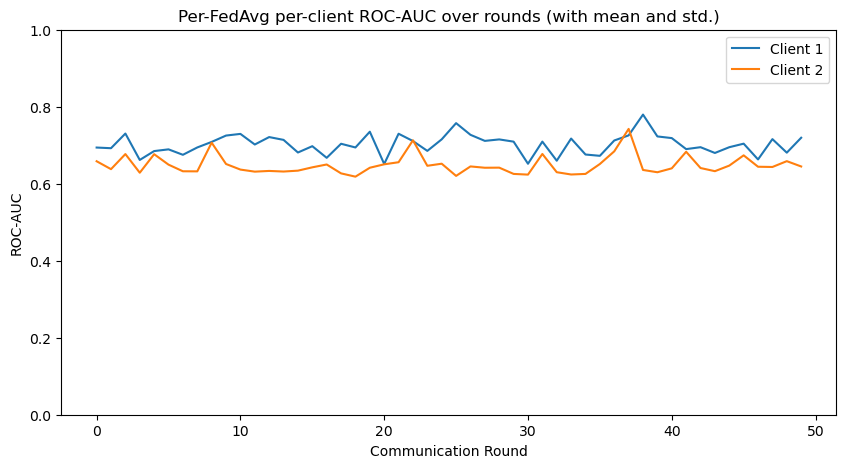

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os

seeds = [42, 1337, 7]
client_ids = [0, 1]
perfedavg_history_dir = "results/perfedavg" 

all_client_roc_auc_histories = {client_id: [] for client_id in client_ids}

found_any_file = False
for seed in seeds:
    file_path = f"{perfedavg_history_dir}/seed_{seed}/meta_history.json"

    if os.path.exists(file_path):
        found_any_file = True
        with open(file_path, "r") as f:
            meta_hist = json.load(f)

        for client_idx in client_ids:
            if 'personalized_auc' in meta_hist and \
               isinstance(meta_hist['personalized_auc'], list) and \
               len(meta_hist['personalized_auc']) > client_idx and \
               isinstance(meta_hist['personalized_auc'][client_idx], list) and \
               len(meta_hist['personalized_auc'][client_idx]) > 0:
                
                all_client_roc_auc_histories[client_idx].append(meta_hist['personalized_auc'][client_idx])
            else:
                print(f"Warning: 'personalized_auc' for Client {client_idx} not found or is empty/incorrectly structured in {file_path}")
    else:
        print(f"Warning: File not found: {file_path}")

else:
    mean_per_client_roc_auc = {}
    std_per_client_roc_auc = {}

    for client_idx in client_ids:
        client_data = np.array(all_client_roc_auc_histories[client_idx])
        
        if client_data.shape[0] > 0: 
            mean_per_client_roc_auc[client_idx] = np.mean(client_data, axis=0)
            std_per_client_roc_auc[client_idx] = np.std(client_data, axis=0)
        else:
            print(f"No data available for Client {client_idx} to calculate mean/std dev. Skipping plot for this client.")
            if client_idx in mean_per_client_roc_auc: del mean_per_client_roc_auc[client_idx]
            if client_idx in std_per_client_roc_auc: del std_per_client_roc_auc[client_idx]

    def plot_multi_clients_roc_auc(mean_histories, std_histories, client_ids, ylim=(0, 1)):
        plt.figure(figsize=(10, 5))
        
        first_client_with_data = None
        for cid in client_ids:
            if cid in mean_histories and len(mean_histories[cid]) > 0:
                first_client_with_data = cid
                break

        if first_client_with_data is not None:
            x = np.arange(len(mean_histories[first_client_with_data]))  # rounds
        else:
            print("No valid data available for any client to determine number of rounds for plotting.")
            return

        for client_id in client_ids:
            if client_id in mean_histories and client_id in std_histories:
                mean = mean_histories[client_id]
                std = std_histories[client_id]
                
                if len(mean) == len(x):
                    plt.plot(x, mean, label=f"Client {client_id + 1}")
                    plt.fill_between(x, mean - std, mean + std, alpha=0.2)
                else:
                    print(f"Skipping plotting for Client {client_id}: Mismatched data length (mean/std vs. rounds).")
            else:
                print(f"Skipping plotting for Client {client_id}: Mean or Std history not available.")

        plt.xlabel("Communication Round")
        plt.ylabel("ROC-AUC")
        plt.title("Per-FedAvg per-client ROC-AUC over rounds (with mean and std.)")
        plt.ylim(ylim)
        plt.legend()
        plt.show()

    if mean_per_client_roc_auc:
        plot_multi_clients_roc_auc(mean_per_client_roc_auc, std_per_client_roc_auc, client_ids=client_ids, ylim=(0, 1))
    else:
        print("\nNo sufficient data to generate the Per-FedAvg ROC-AUC plot across seeds.")

### MTL execution (MOCHA)

In [95]:
clients = [0, 1]
all_client_data_pfl = {}

clientname = {0: "MIMIC-III (Client 1)", 1: "eICU (Client 2)"}

for cid in clients:
    all_client_data_pfl[cid] = load_and_prepare_client_data(
        client_id=cid,
        data_path_prefix="./",
        for_meta_learning=False, # RELOAD BECAUSE WE DONT DO META NO MORE
        split_ratio=0.6,
        seed=42
    )

client_train_loaders = [all_client_data_pfl[cid]['train_loader'] for cid in clients]
client_test_loaders = [all_client_data_pfl[cid]['test_loader'] for cid in clients]
pos_weights_pfl = [all_client_data_pfl[cid]['pos_weight'] for cid in clients]

client_common_static_dims = {cid: all_client_data_pfl[cid]['common_static_dim'] for cid in clients}
client_local_static_dims  = {cid: all_client_data_pfl[cid]['local_static_dim'] for cid in clients}
client_dynamic_dims       = {cid: all_client_data_pfl[cid]['dynamic_dim'] for cid in clients}

# Sanity check
common_dims_set = set(client_common_static_dims.values())
if len(common_dims_set) > 1:
    raise ValueError(f"Common static dimensions differ across clients! Dims found: {common_dims_set}")

  MIMIC-III (Client 1) - Original Xs_common_tr shape: (27585, 6)
  MIMIC-III (Client 1) - Original Xs_local_tr shape: (27585, 4)
  MIMIC-III (Client 1) - Original Xd_tr (dynamic) shape: (27585, 24, 205), Feature Dim: 205
Client 0 (Train): Total samples=27585, Class 0 (Dead)=1892, Class 1 (Alive/Positive for Loss)=25693
  Calculated pos_weight (for 'Alive' class, label 1 in loss): 0.07
  eICU (Client 2) - Original Xs_common_tr shape: (34137, 6)
  eICU (Client 2) - Original Xs_local_tr shape: (34137, 3)
  eICU (Client 2) - Original Xd_tr (dynamic) shape: (34137, 24, 123), Feature Dim: 123
Client 1 (Train): Total samples=34137, Class 0 (Dead)=2441, Class 1 (Alive/Positive for Loss)=31696
  Calculated pos_weight (for 'Alive' class, label 1 in loss): 0.08


In [99]:
seeds = [42, 1337, 7]

for seed in seeds:
    print("\n" + "="*20 + f" Starting MOCHA (Seed {seed}) " + "="*20)

    # Set seed for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Define client-specific model factories (per seed)
    static_backbone_factory = lambda: nn.Sequential(
        nn.Linear(COMMON_STATIC_FEATURES_DIM, COMMON_MLP_HIDDEN_HP),
        nn.ReLU(),
        nn.Dropout(0.2)
    )

    lstm_head_factory = lambda client_dyn_dim, client_local_stat_dim: LSTMHead(
        dynamic_input_dim=client_dyn_dim,
        local_static_input_dim=client_local_stat_dim,
        common_mlp_output_dim=COMMON_MLP_HIDDEN_HP,
        lstm_hidden_size=LSTM_HIDDEN_DIM_HP,
        local_mlp_hidden_size=LOCAL_MLP_HIDDEN_HP,
        head_mlp_hidden_1=HEAD_MLP_HIDDEN_1_HP,
        head_mlp_hidden_2=HEAD_MLP_HIDDEN_2_HP
    )

    # Run MOCHA training
    global_mocha_backbone, mocha_client_heads, mocha_hist = multitask_federated_averaging(
        static_backbone_factory=static_backbone_factory,
        lstm_head_factory=lstm_head_factory,
        train_loaders=client_support_loaders,
        test_loaders=client_test_loaders,
        pos_weights=pos_weights_pfl,
        client_common_static_dims=client_common_static_dims,
        client_local_static_dims=client_local_static_dims,
        client_dynamic_dims=client_dynamic_dims,
        client_ids_list=clients,
        common_static_backbone_output_dim=COMMON_MLP_HIDDEN_HP,
        lstm_hidden_hp=LSTM_HIDDEN_DIM_HP,
        local_mlp_hidden_hp=LOCAL_MLP_HIDDEN_HP,
        head_mlp_hidden_1_hp=HEAD_MLP_HIDDEN_1_HP,
        head_mlp_hidden_2_hp=HEAD_MLP_HIDDEN_2_HP,
        num_rounds=NUM_ROUNDS,
        local_epochs=LOCAL_EPOCHS,
        lr=MOCHA_LR,
        device=DEVICE
    )

    out_path = f"results/mocha/seed_{seed}"
    os.makedirs(out_path, exist_ok=True)

    with open(f"{out_path}/mocha_history.json", "w") as f:
        json.dump(mocha_hist, f)


==================== Starting MOCHA (Seed 42) ====================

=== MT Round 1/50 ===
  [Client 0] inner-train loss: 0.0745
  [Client 1] inner-train loss: 0.0959
  [Client 0] AUC: 0.6923, PR-AUC: 0.9657, BalAcc: 0.5000, Acc: 0.0686, Prec: 0.0000, Rec: 0.0000, F1: 0.0000
  [Client 1] AUC: 0.6207, PR-AUC: 0.9518, BalAcc: 0.5000, Acc: 0.0715, Prec: 0.0000, Rec: 0.0000, F1: 0.0000
Global Personalized MT AUC: 0.619, Acc: 0.930, Prec: 0.930, Rec: 1.000, F1: 0.964, PR-AUC: 0.952

=== MT Round 2/50 ===
  [Client 0] inner-train loss: 0.0621
  [Client 1] inner-train loss: 0.0826
  [Client 0] AUC: 0.7010, PR-AUC: 0.9668, BalAcc: 0.5000, Acc: 0.0686, Prec: 0.0000, Rec: 0.0000, F1: 0.0000
  [Client 1] AUC: 0.6372, PR-AUC: 0.9547, BalAcc: 0.5000, Acc: 0.0715, Prec: 0.0000, Rec: 0.0000, F1: 0.0000
Global Personalized MT AUC: 0.663, Acc: 0.930, Prec: 0.930, Rec: 1.000, F1: 0.964, PR-AUC: 0.959

=== MT Round 3/50 ===
  [Client 0] inner-train loss: 0.0560
  [Client 1] inner-train loss: 0.0777
  [Cl

In [ ]:
import numpy as np
import json
import os

seeds = [42, 1337, 7]
client_ids = [0, 1] 

personalized_metric_keys = {
    'per_client_loss': 'Loss',
    'per_client_precision': 'Precision',
    'per_client_recall': 'Recall',
    'per_client_f1': 'F1-Score',
    'per_client_auc': 'ROC-AUC',       
    'per_client_pr_auc': 'PR-AUC'      
}
output_metrics_order = [
    'Loss', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC'
]

all_client_metrics_final_round = {client_id: {key_json: [] for key_json in personalized_metric_keys.keys()}
                                  for client_id in client_ids}

for seed in seeds:
    file_path = f"results/mocha/seed_{seed}/mocha_history.json"

    if os.path.exists(file_path):
        with open(file_path, "r") as f:
            mocha_hist = json.load(f) 

        for client_idx in client_ids:
            for key_json in personalized_metric_keys.keys():
                if key_json in mocha_hist and isinstance(mocha_hist[key_json], list) and len(mocha_hist[key_json]) > client_idx and len(mocha_hist[key_json][client_idx]) > 0:
                    all_client_metrics_final_round[client_idx][key_json].append(mocha_hist[key_json][client_idx][-1])
                else:
                    pass
    else:
        print(f"Warning: File not found: {file_path}")

summary_metrics_per_client = {client_id: {} for client_id in client_ids}

for client_idx in client_ids:
    for key_json, display_name in personalized_metric_keys.items():
        values = np.array(all_client_metrics_final_round[client_idx][key_json])
        if len(values) > 0:
            mean_val = np.mean(values)
            std_val = np.std(values)
            summary_metrics_per_client[client_idx][display_name] = f"${mean_val:.4f} \\pm {std_val:.4f}$"
        else:
            summary_metrics_per_client[client_idx][display_name] = "N/A"

summary_metrics_per_client

{0: {'Loss': '$0.0015 \\pm 0.0007$',
  'Precision': '$0.9443 \\pm 0.0139$',
  'Recall': '$0.9358 \\pm 0.0891$',
  'F1-Score': '$0.9371 \\pm 0.0403$',
  'ROC-AUC': '$0.6193 \\pm 0.1094$',
  'PR-AUC': '$0.9491 \\pm 0.0173$'},
 1: {'Loss': '$0.0066 \\pm 0.0009$',
  'Precision': '$0.9548 \\pm 0.0102$',
  'Recall': '$0.2712 \\pm 0.3704$',
  'F1-Score': '$0.2995 \\pm 0.3976$',
  'ROC-AUC': '$0.6386 \\pm 0.0162$',
  'PR-AUC': '$0.9529 \\pm 0.0042$'}}

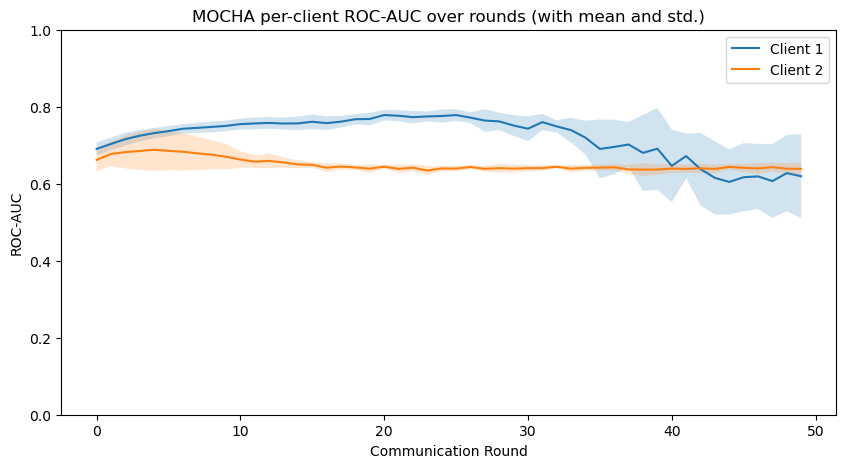

In [ ]:
seeds = [42, 1337, 7]
client_ids = [0, 1]
mocha_history_dir = "results/mocha" 

all_client_roc_auc_histories = {client_id: [] for client_id in client_ids}

found_any_file = False 

for seed in seeds:
    file_path = f"{mocha_history_dir}/seed_{seed}/mocha_history.json"

    if os.path.exists(file_path):
        found_any_file = True 
        with open(file_path, "r") as f:
            mocha_hist = json.load(f)

        for client_idx in client_ids:
            if 'per_client_auc' in mocha_hist and \
               isinstance(mocha_hist['per_client_auc'], list) and \
               len(mocha_hist['per_client_auc']) > client_idx and \
               isinstance(mocha_hist['per_client_auc'][client_idx], list) and \
               len(mocha_hist['per_client_auc'][client_idx]) > 0:
                
                all_client_roc_auc_histories[client_idx].append(mocha_hist['per_client_auc'][client_idx])
            else:
                print(f"Warning: 'per_client_auc' for Client {client_idx} not found or is empty/incorrectly structured in {file_path}")
    else:
        print(f"Warning: File not found: {file_path}")

if not found_any_file:
    print("\nError: No MOCHA history files were found. Cannot plot ROC-AUC over rounds. "
          "Please ensure unique 'mocha_history.json' files from different seed runs "
          "are placed in 'results/mocha/seed_X/' directories.")
else:
    mean_per_client_roc_auc = {}
    std_per_client_roc_auc = {}

    for client_idx in client_ids:
        client_data = np.array(all_client_roc_auc_histories[client_idx])
        
        if client_data.shape[0] > 0:
            mean_per_client_roc_auc[client_idx] = np.mean(client_data, axis=0)
            std_per_client_roc_auc[client_idx] = np.std(client_data, axis=0)
        else:
            print(f"No data available for Client {client_idx} to calculate mean/std dev. Skipping plot for this client.")
            # If no data for a client, remove it from the dictionaries to prevent plotting issues
            if client_idx in mean_per_client_roc_auc: del mean_per_client_roc_auc[client_idx]
            if client_idx in std_per_client_roc_auc: del std_per_client_roc_auc[client_idx]

    def plot_multi_clients_roc_auc(mean_histories, std_histories, client_ids, ylim=(0, 1)):
        plt.figure(figsize=(10, 5))
        
        first_client_with_data = None
        for cid in client_ids:
            if cid in mean_histories and len(mean_histories[cid]) > 0:
                first_client_with_data = cid
                break

        if first_client_with_data is not None:
            x = np.arange(len(mean_histories[first_client_with_data])) 
        else:
            print("No valid data available for any client to determine number of rounds for plotting.")
            return

        for client_id in client_ids:
            if client_id in mean_histories and client_id in std_histories:
                mean = mean_histories[client_id]
                std = std_histories[client_id]
                
                if len(mean) == len(x): 
                    plt.plot(x, mean, label=f"Client {client_id +1 }")
                    plt.fill_between(x, mean - std, mean + std, alpha=0.2)
                else:
                    print(f"Skipping plotting for Client {client_id}: Mismatched data length (mean/std vs. rounds).")
            else:
                print(f"Skipping plotting for Client {client_id}: Mean or Std history not available.")

        plt.xlabel("Communication Round")
        plt.ylabel("ROC-AUC")
        plt.title("MOCHA per-client ROC-AUC over rounds (with mean and std.)") # Changed title to MOCHA
        plt.ylim(ylim)
        plt.legend()
        plt.show()

    if mean_per_client_roc_auc: 
        plot_multi_clients_roc_auc(mean_per_client_roc_auc, std_per_client_roc_auc, client_ids=client_ids, ylim=(0, 1.0)) 
    else:
        print("\nNo sufficient data to generate the MOCHA ROC-AUC plot across seeds.")